In [119]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier


import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

import random

import optuna

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = text.replace('machine learning', 'machinelearning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X


class Optimize_by_Optuna:
    def __init__(self, data, features, target_colname, target_name_2=None, _objective=None):
        self.data = data
        self.features = features
        self.target = target_colname
        if not target_colname:
            self.target_2 = target_colname
        else:
            self.target_2 = target_name_2
        self._objective = _objective
        
    
    def make_score(self, y, preds):
        s_1=1 - metrics.accuracy_score(y, preds)
        s_2=list(self.model.best_score['valid_1'].values())[0]

        return (s_1+s_2)/2

    def objective(self, trial):
                        
        PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
        

            'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.01, 1.8),


            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'subsample': trial.suggest_uniform('subsample', 0.4, 0.9),
            'subsample_freq': trial.suggest_uniform('subsample_freq', 0.4, 0.9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 4, 2*5),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.0001, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.0001, 10.0),
        }
        
        score = 0
        k = StratifiedKFold(n_splits=5)
        for trn, val in k.split(self.data, self.data[self.target_2]):
            train_df = self.data.iloc[trn,:]
            val_df = self.data.iloc[val,:]
            train_set= lgb.Dataset(train_df[self.features],  train_df[self.target])
            val_set = lgb.Dataset(val_df[self.features],  val_df[self.target])   
            
            self.model = lgb.train(
                train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
                early_stopping_rounds=200, verbose_eval=500
                )
                
            preds = self.model.predict(val_df[self.features])
            preds = np.round(preds)
            y = val_df[self.target]
            s = self.make_score(y, preds)
            score+=s/5
            
        return score


class Null_Importance:
    def __init__(self, train_X, train_y, PARAMS, y_2=None):
        self.train_X = train_X
        self.train_y = train_y
        self.y_2= y_2
        self.PARAMS = PARAMS

    def make_null_importance_df(self):
        null_importance=pd.DataFrame()
        null_importance['col'] = self.train_X.columns.tolist()
        try:
            for i in range(50):
                tmp_null_importance=[]
                
                _train_y = self.train_y.apply(lambda x: random.choice([0,1]))
                _train_y_2 = self.y_2.sample(frac=1).values
                
                print(f"""
                
                Train Null Importance   {i+1}
                
                """ )
                k = StratifiedKFold(n_splits=5)
                for trn, val in k.split(self.train_X, _train_y_2):
                    trn_X, val_X = self.train_X.iloc[trn,:], self.train_X.iloc[val,:]
                    trn_y, val_y = _train_y.iloc[trn].astype(int), _train_y.iloc[val].astype(int)
                    train_set = lgb.Dataset(trn_X, trn_y)
                    val_set = lgb.Dataset(val_X, val_y)

                    model = lgb.train(params=self.PARAMS,
                                      train_set=train_set, 
                                      valid_sets=[train_set, val_set],
                                    num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
                    
                    preds = model.predict(val_X)
                    tmp_null_importance.append(model.feature_importance('gain'))
                null_importance[f'null_importance_{i+1}'] = np.mean(tmp_null_importance, axis=0)
            return null_importance
        except:
            return null_importance

    def calu_importance(self, importance_df, null_importance_df):
        importance_df = pd.merge(
            importance_df, null_importance_df, on='col'
            )
        null_importance_col = [col for col in importance_df.columns if 'null' in col]
        null_importance=pd.DataFrame()
        for idx, row in importance_df.iterrows():
            acc_v = 1e-10+row['true_importance']
            null_v = 1+np.percentile(row[null_importance_col], 75)
            null_importance[row['col']] = [np.log(acc_v/null_v)]
        null_importance = null_importance.T
        return null_importance

    def all_flow(self):
        k = StratifiedKFold(n_splits=5)
        score=[]
        importance=[]

        importance_df=pd.DataFrame()
        importance_df['col'] = self.train_X.columns
        print("""
        
        Train True Importance
        
        """ )
        for trn, val in k.split(self.train_X, self.y_2):
            trn_X, val_X = self.train_X.iloc[trn,:], self.train_X.iloc[val,:]
            trn_y, val_y = self.train_y.iloc[trn].astype(int), self.train_y.iloc[val].astype(int)
            train_set = lgb.Dataset(trn_X, trn_y)
            val_set = lgb.Dataset(val_X, val_y)
            
            PARAMS['random_state']+=1
            model = lgb.train(params=self.PARAMS, train_set=train_set, valid_sets=[train_set, val_set],
                            num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
            preds = model.predict(val_X)
            importance.append(model.feature_importance('gain'))
        importance_df['true_importance'] = np.mean(importance, axis=0)
        
        print("""
        
        Train Null Importance
        
        """ )
        try:
            null_importance_df = self.make_null_importance_df()
        except:
            pass
        print("""
        
        Calulate null_null_importance
        
        """ )
        null_importance = self.calu_importance(importance_df, null_importance_df)
        null_importance = null_importance.reset_index()
        null_importance.columns = ['col', 'score']
        null_importance = null_importance.sort_values('score', ascending=False)
        return null_importance

In [5]:
df = pd.concat([
    pd.read_csv('train.csv'),
    pd.read_csv('test.csv')],
    axis=0,ignore_index=True)
preprocessing = Preprocessing()
df.description = df.description.apply(lambda x: preprocessing.change_text(x))

In [6]:
X = preprocessing.vectorize_tfidf(df)
X = pd.concat([df.jobflag, X], axis=1)
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

In [15]:
feature = ['abil', 'abl', 'accept', 'access', 'accord', 'account', 'accur', 'accuraci', 'achiev', 'acquisit', 'across', 'act', 'action', 
           'activ', 'ad', 'addit', 'address', 'adher', 'administr', 'advanc', 'advis', 'advisor', 'agil', 'agre', 'ai', 'algorithm', 
           'align', 'analys', 'analysi', 'analyst', 'analyt', 'analyz', 'api', 'appli', 'applic', 'approach', 'appropri', 'approv', 
           'architect', 'architectur', 'area', 'assembl', 'assess', 'assign', 'assist', 'audienc', 'autom', 'avail', 'aw', 'back',
           'backend', 'base', 'basic', 'behavior', 'benefit', 'best', 'board', 'bug', 'build', 'busi', 'call', 'can', 'candid', 'capabl',
           'capac', 'case', 'caus', 'challeng', 'chang', 'clearli', 'client', 'clinic', 'close', 'cloud', 'cluster', 'coach', 'code', 
           'collabor', 'collect', 'commerci', 'commiss', 'commun', 'compani', 'complet', 'complex', 'complianc', 'compon', 'comput', 
           'concept', 'conduct', 'confer', 'configur', 'connect', 'consist', 'construct', 'consult', 'content', 'continu', 'contract',
           'contribut', 'control', 'coordin', 'core', 'corpor', 'correct', 'cost', 'creat', 'creation', 'creativ', 'critic', 'cross', 
           'cultur', 'current', 'custom', 'cycl', 'daili', 'dashboard', 'data', 'databas', 'dataset', 'date', 'deadlin', 'debug', 'decis',
           'deep', 'defect', 'defin', 'definit', 'deliv', 'deliver', 'deliveri', 'demand', 'demonstr', 'depart', 'depend', 'deploy', 'depth',
           'deriv', 'design', 'desir', 'detail', 'detect', 'determin', 'develop', 'devic', 'devop', 'differ', 'digit', 'direct', 'disciplin',
           'discoveri', 'discuss', 'distribut', 'divers', 'document', 'domain', 'draw', 'drive', 'duti', 'dynam', 'edg', 'educ', 'effect',
           'effici', 'effort', 'electron', 'email', 'embed', 'employe', 'enabl', 'end', 'engag', 'engin', 'enhanc', 'ensur', 'enterpris',
           'environ', 'equip', 'erp', 'escal', 'establish', 'estim', 'etc', 'evalu', 'event', 'excel', 'execut', 'exist', 'expand', 'experi',
           'expert', 'expertis', 'explain', 'explor', 'exploratori', 'extern', 'extract', 'face', 'facilit', 'failur', 'featur', 'feder', 
           'field', 'find', 'fix', 'flow', 'focu', 'follow', 'form', 'formul', 'framework', 'front', 'full', 'function', 'futur', 'gain',
           'gap', 'gather', 'gener', 'global', 'go', 'goal', 'good', 'govern', 'group', 'grow', 'growth', 'guid', 'guidanc', 'hand', 
           'hardwar', 'healthcar', 'help', 'high', 'highli', 'hoc', 'idea', 'identifi', 'impact', 'implement', 'improv', 'incid', 'includ',
           'increas', 'independ', 'individu', 'industri', 'influenc', 'inform', 'infrastructur', 'initi', 'innov', 'input', 'insight',
           'inspect', 'instal', 'integr', 'intellig', 'interact', 'interfac', 'intern', 'interpret', 'investig', 'issu', 'iter', 'java',
           'job', 'junior', 'keep', 'key', 'knowledg', 'languag', 'larg', 'latest', 'lead', 'leader', 'leadership', 'learn', 'level', 
           'leverag', 'librari', 'life', 'like', 'limit', 'linux', 'log', 'logic', 'machin', 'machinelearn', 'maintain', 'mainten', 
           'make', 'manag', 'manner', 'manufactur', 'map', 'market', 'materi', 'matter', 'may', 'measur', 'mechan', 'medic', 'meet',
           'member', 'mentor', 'met', 'method', 'methodolog', 'metric', 'microsoft', 'migrat', 'mission', 'mobil', 'model', 'moder',
           'modifi', 'modul', 'monitor', 'multi', 'multipl', 'must', 'necessari', 'need', 'net', 'network', 'new', 'next', 'non', 'novel',
           'object', 'obtain', 'ongo', 'open', 'oper', 'opportun', 'optim', 'order', 'organ', 'organiz', 'orient', 'outcom', 'outsid',
           'overal', 'overse', 'part', 'parti', 'particip', 'partner', 'partnership', 'pattern', 'payrol', 'peer', 'perform', 'person',
           'personnel', 'pipelin', 'plan', 'platform', 'point', 'polici', 'posit', 'post', 'potenti', 'practic', 'pre', 'predict', 'prepar', 
           'present', 'price', 'principl', 'prior', 'priorit', 'proactiv', 'problem', 'procedur', 'process', 'produc', 'product', 
           'profession', 'program', 'progress', 'project', 'promot', 'proof', 'propos', 'prospect', 'protocol', 'prototyp','provid', 
           'purpos', 'python', 'qa', 'qualifi', 'qualiti', 'queri', 'question', 'quickli', 'real', 'recommend', 'referr', 'refin', 'regard',
           'region', 'regul', 'regular', 'regulatori', 'relat', 'relationship', 'releas', 'relev', 'reliabl', 'report','repres', 'request',
           'requir', 'research', 'resid', 'resolut', 'resolv', 'resourc', 'respons', 'result', 'retail', 'review', 'rigor', 'risk', 'roadmap',
           'role', 'root', 'rule', 'run', 'safeti', 'sale', 'scalabl', 'scale', 'schedul', 'scienc', 'scientist', 'scope', 'script', 'scrum',
           'secur', 'segment', 'select', 'self', 'sell', 'senior', 'serv', 'server', 'servic', 'set', 'share', 'show', 'simul', 'site',
           'skill', 'small', 'softwar', 'solut', 'solv', 'sourc', 'specif', 'sql', 'stack', 'staff', 'stakehold', 'standard', 'state',
           'statist', 'statu', 'stay', 'store', 'stori', 'strateg', 'strategi', 'stream', 'strong', 'structur', 'studi', 'subject', 
           'success', 'suggest', 'supplier', 'support', 'system', 'take', 'target', 'task', 'team', 'technic', 'techniqu', 'technolog', 
           'term','test', 'think', 'thought', 'throughout', 'time', 'timelin', 'tool', 'top', 'track', 'train', 'transform', 'translat',
           'travel', 'trend', 'troubleshoot', 'tune', 'understand', 'unit', 'updat', 'upgrad', 'use', 'user', 'util', 'valid',
           'valu', 'variou', 'vehicl', 'vendor', 'verif', 'verifi', 'version', 'via', 'vision', 'visual', 'way',
           'web', 'well', 'wide', 'will', 'window', 'within', 'work', 'workflow','write']

PARAMS_1={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
   'tweedie_variance_power': 1.349969119190657, 'max_bin': 212, 'subsample': 0.5774043241504451, 'subsample_freq': 0.7045972939301558, 
    'learning_rate': 0.16528226095247364, 'num_leaves': 4, 'feature_fraction': 0.9964784224971625,
    'bagging_freq': 6, 'min_child_samples': 23, 'lambda_l1': 0.016924825494747078, 'lambda_l2': 0.0008031532180312293
}


PARAMS_2={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3014991003823067, 'max_bin': 134, 'subsample': 0.8990859498726816, 'subsample_freq': 0.5274951186330312,
    'learning_rate': 0.3937162652059595, 'num_leaves': 5, 'feature_fraction': 0.8861294810479933, 'bagging_freq': 5,
    'min_child_samples': 28, 'lambda_l1': 6.037171725930821, 'lambda_l2': 0.0025254105473444784
}

PARAMS_3={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    #'objective': 'tweedie','metric': 'tweedie',
     
    'objective': 'xentropy','metric': 'xentropy',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'max_bin': 50, 'subsample': 0.8509082362331666, 'subsample_freq': 0.6958806976511948, 'learning_rate': 0.09406169926162017,
    'num_leaves': 7, 'feature_fraction': 0.7562554580497556, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.00021420978217365439,
    'lambda_l2': 0.011867471326820044
}

PARAMS_4={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3572492826220748, 'max_bin': 169, 'subsample': 0.6874225607452877, 'subsample_freq': 0.5369168449326642,
    'learning_rate': 0.0353671206084155, 'num_leaves': 8, 'feature_fraction': 0.9508830019260512, 
    'bagging_freq': 2, 'min_child_samples': 63, 'lambda_l1': 8.281467382972142, 'lambda_l2': 0.1428656656583413
}

param_list = [PARAMS_1, PARAMS_2, PARAMS_3, PARAMS_4]

In [9]:
train_df = train_df[feature+['jobflag']]
test_df = test_df[feature]

In [10]:
train_df.head()

,abil,abl,accept,access,accord,account,accur,accuraci,achiev,acquisit,...,web,well,wide,will,window,within,work,workflow,write,jobflag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215403,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.0


In [11]:
test_df.head()

,abil,abl,accept,access,accord,account,accur,accuraci,achiev,acquisit,...,way,web,well,wide,will,window,within,work,workflow,write
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.544329,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [62]:
def make_offdf(train_df, feature, params_list):
    k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
    
    y_1 = train_df.jobflag.apply(lambda x: 1 if x==1 else 0)
    y_2 = train_df.jobflag.apply(lambda x: 1 if x==2 else 0)
    y_3 = train_df.jobflag.apply(lambda x: 1 if x==3 else 0)
    y_4 = train_df.jobflag.apply(lambda x: 1 if x==4 else 0)
    
    off_df = []
    
    for trn, val in k.split(train_df, train_df.jobflag):
        train_X, val_X = train_df.iloc[trn,:][feature], train_df.iloc[val,:][feature]
        tmp_off_df = train_df.iloc[val,:]
        c=1
        for y, param in zip([y_1, y_2, y_3, y_4], params_list):
            train_y, val_y = y.iloc[trn], y.iloc[val]
            train_set= lgb.Dataset(train_X,  train_y)
            val_set = lgb.Dataset(val_X,  val_y)   

            model = lgb.train(
                train_set=train_set, valid_sets=[train_set, val_set], params=param, num_boost_round=3000, 
                early_stopping_rounds=200, verbose_eval=500
            )
            tmp_off_df[f'preds_{c}'] = model.predict(val_X)
            c+=1
            
        off_df.append(tmp_off_df)
    off_df = pd.concat(off_df, axis=0)
    return off_df.reset_index(drop=True)

In [63]:
off_df = make_offdf(train_df, feature, param_list)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.44053	valid_1's tweedie: 1.46228
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	training's tweedie: 0.921552	valid_1's tweedie: 0.98783
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[226]	training's cross_entropy: 0.334137	valid_1's cross_entropy: 0.465248
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36352	valid_1's tweedie: 1.37861
[1000]	training's tweedie: 1.34188	valid_1's tweedie: 1.37521
Early stopping, best iteration is:
[1120]	training's tweedie: 1.33762	valid_1's tweedie: 1.37406
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's tweedie: 1.41697	valid_1's tweedie: 1.46835
Training until validation scores don't improve for 200 rounds
Early stoppi

In [64]:
pd.concat([
    pd.get_dummies(off_df.jobflag)[[1,2,3,4]],
    off_df[[ 'preds_1', 'preds_2', 'preds_3', 'preds_4']]
], axis=1).corr()

,1.0,2.0,3.0,4.0,preds_1,preds_2,preds_3,preds_4
1.0,1.000000,-0.190896,-0.489229,-0.259152,0.506817,0.147409,-0.446349,-0.152492
2.0,-0.190896,1.000000,-0.345280,-0.182900,0.119368,0.377547,-0.197172,-0.170386
3.0,-0.489229,-0.345280,1.000000,-0.468737,-0.392012,-0.224782,0.584475,-0.108653
4.0,-0.259152,-0.182900,-0.468737,1.000000,-0.126361,-0.176079,-0.113225,0.430291
preds_1,0.506817,0.119368,-0.392012,-0.126361,1.000000,0.286276,-0.648559,-0.209572
preds_2,0.147409,0.377547,-0.224782,-0.176079,0.286276,1.000000,-0.372438,-0.319862
preds_3,-0.446349,-0.197172,0.584475,-0.113225,-0.648559,-0.372438,1.000000,-0.139463
preds_4,-0.152492,-0.170386,-0.108653,0.430291,-0.209572,-0.319862,-0.139463,1.000000


In [66]:
min_value = off_df.jobflag.value_counts().min()
min_value

348

In [78]:
random.seed(2020)
np.random.seed(2020)
logit = LogisticRegression()

In [139]:
off_df.sample(n=10, random_state=2020)

,abil,abl,accept,access,accord,account,accur,accuraci,achiev,acquisit,...,window,within,work,workflow,write,jobflag,preds_1,preds_2,preds_3,preds_4
447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.038996,0.071379,0.901825,0.039188
2104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.229664,0.057823,0.621675,0.294201
474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.131232,0.032734,0.604222,0.263042
2792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.106060,0.027210,0.462804,0.409050
830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.155340,0.048459,0.600843,0.218269
1931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.063779,0.013921,0.897799,0.059237
621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.120459,0.053776,0.382556,0.502791
1598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.175510,0.072444,0.513700,0.242473
2068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.112773,0.028752,0.457676,0.361673
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.146945,0.146437,0.542121,0.164349


In [154]:
k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
off_df_2=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_df = off_df.iloc[trn,:]
    val_df  =  off_df.iloc[val,:]
    
    min_value = trn_df.jobflag.value_counts().min()
    
    preds = np.zeros(shape=(len(val_df),4))
    
    for i in tqdm(range(300)):
        tmp_trn_df = pd.concat(
        [trn_df[trn_df.jobflag==1].sample(n=min_value, random_state=i),
         trn_df[trn_df.jobflag==2].sample(n=min_value, random_state=i),
         trn_df[trn_df.jobflag==3].sample(n=min_value, random_state=i),
         trn_df[trn_df.jobflag==4].sample(n=min_value, random_state=i)], axis=0).reset_index(drop=True)
        tmp_trn_X = tmp_trn_df[[ 'preds_1', 'preds_2', 'preds_3', 'preds_4']]
        tmp_trn_y = tmp_trn_df['jobflag']
        
        
        for penalty  in [ 'l2']:
            for m in range(20):
                logit = LogisticRegression(penalty=penalty, random_state=m)
                logit.fit(tmp_trn_X, tmp_trn_y)

                    #ridge_cls = RidgeClassifier()
                    #ridge_cls.fit(tmp_trn_X, tmp_trn_y)

                    #kncls = KNeighborsClassifier(n_neighbors=4)
                    #kncls.fit(tmp_trn_X, tmp_trn_y)
                preds += logit.predict_proba(val_df[[ 'preds_1', 'preds_2', 'preds_3', 'preds_4']])
        
    val_df[f'preds'] = np.argmax(preds, axis=1)+1
    off_df_2.append(val_df)
off_df_2 = pd.concat(off_df_2, axis=0).reset_index(drop=True)

In [155]:
metrics.f1_score(off_df_2.jobflag, off_df_2.preds, average='macro')

0.5530455910237906

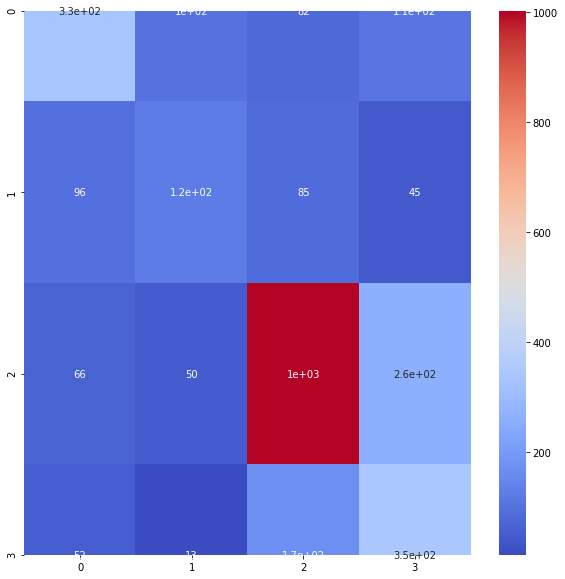

In [156]:
plt.figure(figsize=(10,10))
cnfn_matrix = pd.DataFrame(metrics.confusion_matrix(off_df_2.jobflag, off_df_2.preds))
#cnfn_matrix.index = 
sns.heatmap(cnfn_matrix, annot=True, cmap='coolwarm')

In [157]:
cnfn_matrix

,0,1,2,3
0,334,100,82,108
1,96,122,85,45
2,66,50,1002,258
3,52,13,170,348
